In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCNN_Inception_module-v2-reduced-no-inception-BN-after-activation"


/home/jelinek/recetox/histoseg/notebooks/MyCNN


In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same', activation='relu')(inputs)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same', activation='relu')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same', activation='relu')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), padding='same', activation='relu')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), padding='same', activation='relu')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), padding='same', activation='relu')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=11, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [3]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64,

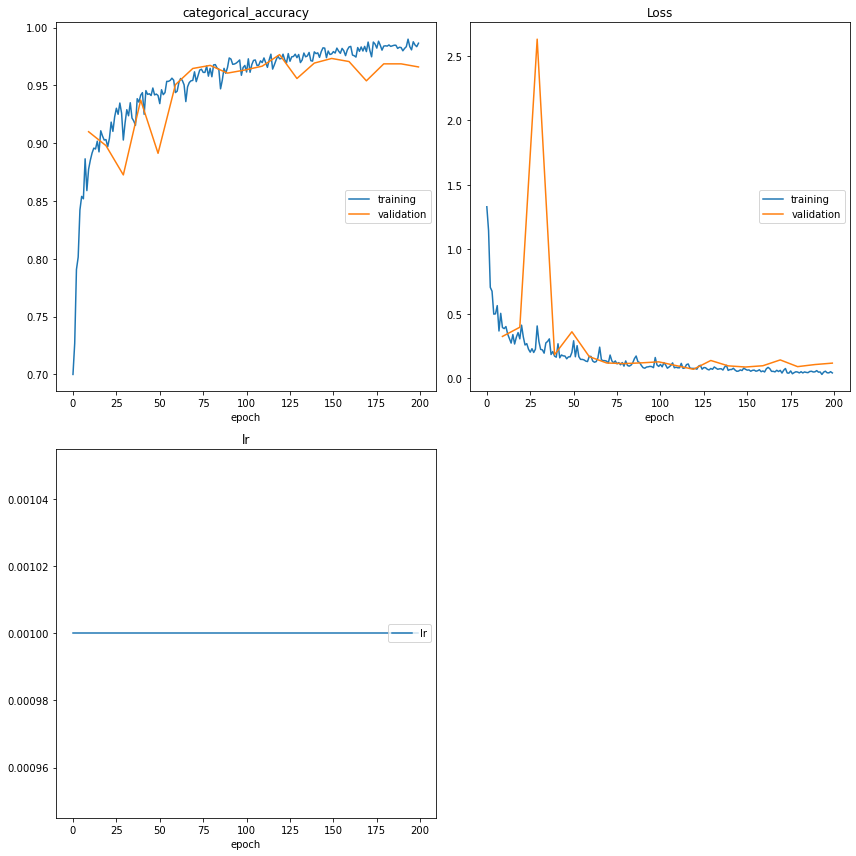

categorical_accuracy
	training         	 (min:    0.700, max:    0.990, cur:    0.987)
	validation       	 (min:    0.873, max:    0.977, cur:    0.966)
Loss
	training         	 (min:    0.031, max:    1.330, cur:    0.042)
	validation       	 (min:    0.071, max:    2.628, cur:    0.118)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
250/250 [==============================] - 21s 82ms/step - loss: 0.0422 - categorical_accuracy: 0.9865 - val_loss: 0.1181 - val_categorical_accuracy: 0.9660 - lr: 0.0010
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.6822ms
Confusion Matrix
[[332   1   2   0   0   0   0   0   0   0   0]
 [  3  51   7   1   2   0   0   0   0   0   0]
 [  1   3 141   0   0   0   0   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0]
 [  1   0   0   2 541   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   4   9   0   0   0  64   0   0   0   0]
 [  0   0   2   0   0   0   0  84   0   0   0]
 [

In [4]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [5]:
pipeline.save_pipeline()

In [6]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           pipeline_name=name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1499 images belonging to 11 classes.


TypeError: eval_model() missing 1 required positional argument: 'pipeline_name'

In [3]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [3]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=False, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, include_unknown=False)

Processing region 120 out of 120
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 2132.5434787273407 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 1599360 out of 1599360
Processing image took 5139.928570985794 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 1544036 out of 1544036
Processing image took 4829.550802946091 seconds
Processing region 567 out of 567
Post-processing image...
Processing grid point 3520448 out of 3520448
Processing image took 11271.001614570618 seconds
Aggregated evaluation: 
[[495257   7488   6696    147    987    150      5    627      1      0
   17741]
 [  2872  36975   7528  10195   7900    339   1291   6695     86      0
    3208]
 [  1865   8579  20841   4631   3342    188   2078   4033    777      0
    6232]
 [  2226    186      0   1041     84     14      0      0      0      0
    8974]
 [  1592   6581   2605  60612 173003    121 

In [4]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         128, pipeline.params.class_names,
                                         save_segmentations=False, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, include_unknown=False)

Processing region 120 out of 120
Post-processing image...
Processing grid point 41664 out of 41664
Processing image took 162.50092458724976 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 99960 out of 99960
Processing image took 365.8585171699524 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 96577 out of 96577
Processing image took 338.4056761264801 seconds
Processing region 567 out of 567
Post-processing image...
Processing grid point 220296 out of 220296
Processing image took 732.8731393814087 seconds
Aggregated evaluation: 
[[31211   566   465   232    42     3     0    25     0     0   498]
 [   67  2764   642    57  1077    16    27    30     7     0   119]
 [  151   455  1833    67   144     8     3   175     1     0   431]
 [   68     9     0    38     1     0     0     0     0     0   684]
 [   31   427   236  2220 12964    18    23    12     0     0     0]
 [    1     0    18   158     0    55   